In [1]:
import torch
import pandas as pd
import numpy as np
from numpy import random
import torch.nn as nn
from torch.amp import autocast
from matplotlib.colors import LogNorm
import matplotlib.pyplot as plt
from tabulate import tabulate

from modules import EDMPrecond, MaxScalePredictor
from diffusion import EdmSampler
from utils import *
from evaluate import evaluate, save_predictions
from metrics import calculate_dtw_distances, calculate_dtw_for_index, plot_dtw_alignment_for_index, calculate_wasserstein_distance

Importing the dtw module. When using in academic works please cite:
  T. Giorgino. Computing and Visualizing Dynamic Time Warping Alignments in R: The dtw Package.
  J. Stat. Soft., doi:10.18637/jss.v031.i07.



In [2]:
device_name = 'cuda:0'
name = "stgF_edm_e30_bs16_do10_cgt10_cg2_norm"
cfg_scale = 2
noise_steps = 20


#-------------------------------------------------------------
test_data_path = "../data/val_data_stg7_norm.csv"
#test_data_path = "../data/for_testing.csv"
predictions_path = "results/predictions/preds_" + name + ".csv"
model_path = "models/" + name + "/ema_ckpt.pt"
scale_predictor_path = "models/" + name + "/scale_predictor.pt"

# Make predictions on test data

In [3]:
x_real, cond_vectors, predictions = evaluate(device=device_name,
                                             test_csv_path=test_data_path,
                                             model_path=model_path,
                                             scale_predictor_path=scale_predictor_path,
                                             n_samples=1,
                                             s_type='edm',
                                             cfg_scale=cfg_scale,
                                             noise_steps=noise_steps)

Testing loop: 100%|█████████████████████████████████████| 2045/2045 [22:13<00:00,  1.53it/s]


In [4]:
x_real = np.array(x_real)

In [5]:
predictions = np.array(predictions)

In [6]:
mse = np.mean((np.array(x_real) - np.array(predictions)[:, 0, 0, :]) ** 2)
print(f"Mean test mse error: {mse}")

Mean test mse error: 0.0010925064104177764


# Save predictions

In [7]:
x_real_str = [','.join(map(str, row)) for row in x_real]
cond_vectors_str = [','.join(map(str, row)) for row in cond_vectors]
preds_str = [','.join(map(str, row)) for row in predictions[:, 0, 0, :]]

df = pd.DataFrame({'x_real': x_real_str, 'cond_vectors': cond_vectors_str, 'predictions': preds_str})
df.to_csv(predictions_path, index=False)

In [8]:
df.head()

,x_real,cond_vectors,predictions
0,"-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-...","-0.34779998660087585,-0.41510000824928284,-0.8...","-0.9990878105163574,-0.999067485332489,-0.9991..."
1,"-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-...","-0.34779998660087585,-0.41510000824928284,-0.8...","-0.9994308352470398,-0.9995107054710388,-0.999..."
2,"-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-...","-0.34779998660087585,-0.41510000824928284,-0.8...","-0.9995365738868713,-0.9996657967567444,-0.999..."
3,"-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-...","-0.34779998660087585,-0.41510000824928284,-0.8...","-0.9995232820510864,-0.9995223879814148,-0.999..."
4,"-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-...","-0.34779998660087585,-0.41510000824928284,-0.8...","-0.9995884299278259,-0.9994347095489502,-0.999..."


In [9]:
# Function to convert comma-separated strings to lists of floats
def str_to_float_list(s):
    return np.array(list(map(float, s.split(','))))

x_real = np.array([str_to_float_list(row) for row in df['x_real']])
cond_vectors = np.array([str_to_float_list(row) for row in df['cond_vectors']])
predictions = np.array([str_to_float_list(row) for row in df['predictions']])

df.head()

,x_real,cond_vectors,predictions
0,"-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-...","-0.34779998660087585,-0.41510000824928284,-0.8...","-0.9990878105163574,-0.999067485332489,-0.9991..."
1,"-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-...","-0.34779998660087585,-0.41510000824928284,-0.8...","-0.9994308352470398,-0.9995107054710388,-0.999..."
2,"-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-...","-0.34779998660087585,-0.41510000824928284,-0.8...","-0.9995365738868713,-0.9996657967567444,-0.999..."
3,"-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-...","-0.34779998660087585,-0.41510000824928284,-0.8...","-0.9995232820510864,-0.9995223879814148,-0.999..."
4,"-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-...","-0.34779998660087585,-0.41510000824928284,-0.8...","-0.9995884299278259,-0.9994347095489502,-0.999..."


# Intro into data

In [10]:
# Find indices and values greater than 0.5
indices = np.where(np.any(x_real > 0.5, axis=1))[0]
filtered_values = [x_real[idx][x_real[idx] > 0.5] for idx in indices]
filtered_predictions = [predictions[idx][x_real[idx] > 0.5] for idx in indices]

# Flatten results and take the first 50
flat_filtered_values = np.concatenate(filtered_values)[:50]
flat_filtered_predictions = np.concatenate(filtered_predictions)[:50]

# Print the results side by side
print("Filtered Values (greater than 0.5) from x_real and corresponding Predictions:")
for value, prediction in zip(flat_filtered_values, flat_filtered_predictions):
    print(f"{value:.5f}\t\t\t{prediction:.5f}")

Filtered Values (greater than 0.5) from x_real and corresponding Predictions:
0.50698			0.41325
0.50698			0.40573
0.60785			0.33449
0.67365			0.40994
0.71205			0.45537
0.67921			0.44792
0.59647			0.38499
0.56111			0.36364
0.61201			0.40845
0.59793			0.39530
0.52645			0.33471
0.50782			0.32473
0.58487			0.39959
0.64452			0.44673
0.63170			0.43912
0.55646			0.37555
0.51323			0.42921
0.50540			0.42655
0.53860			0.39387
0.58075			0.43070
0.57043			0.43164
0.55325			0.43872
0.53291			0.43357
0.54324			0.42491
0.51541			0.41537
0.54408			0.30746
0.61363			0.38821
0.66453			0.42127
0.63295			0.41886
0.53020			0.34509


In [11]:
# Find indices where predictions > 0.8 and corresponding x_real < 0.5
indices = np.where((predictions > 0.8) & (x_real < 0.1))

# Extract filtered values from x_real and predictions
filtered_x_real = x_real[indices]
filtered_predictions = predictions[indices]

# Print the results side by side
print("Filtered x_real (values < 0.1) and corresponding Predictions (values > 0.8):")
for x_val, pred_val in zip(filtered_x_real.flatten(), filtered_predictions.flatten()):
    print(f"{x_val:.5f}\t\t\t{pred_val:.5f}")

Filtered x_real (values < 0.1) and corresponding Predictions (values > 0.8):


# Visualization of results

In [12]:
wavelengths = np.load('../data/wavelengths.npy')

In [13]:
wavelengths

array([ 634.835144,  635.296997,  635.758911, ..., 1123.063232,
       1123.557739, 1124.052368])

## Plot predictions

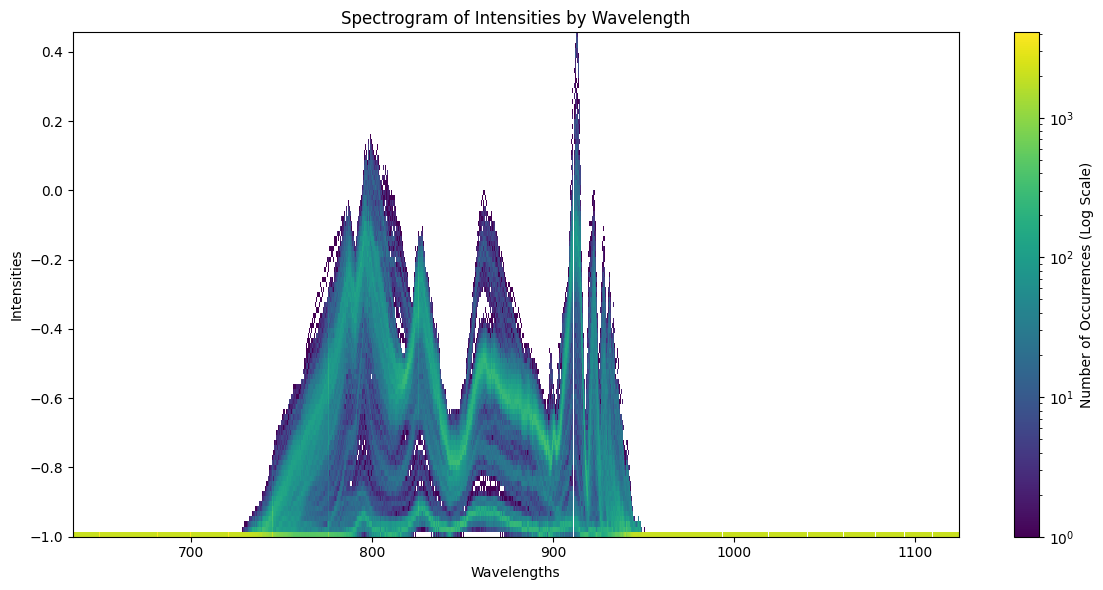

In [14]:
create_spectrogram(wavelengths, predictions, label="Spectrogram of Intensities by Wavelength")

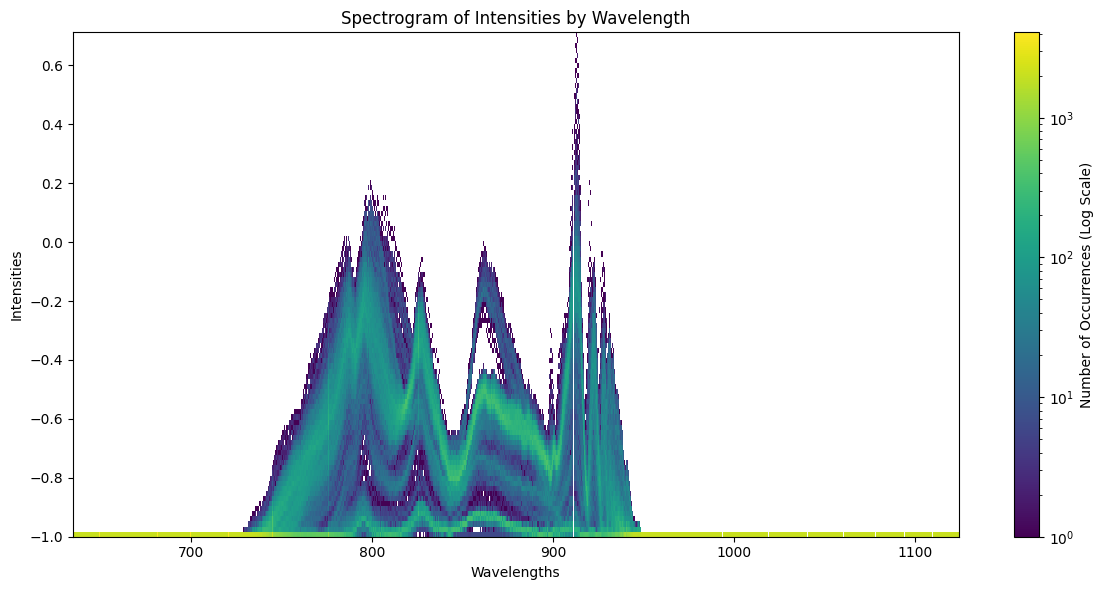

In [15]:
create_spectrogram(wavelengths, x_real, label="Spectrogram of Intensities by Wavelength")

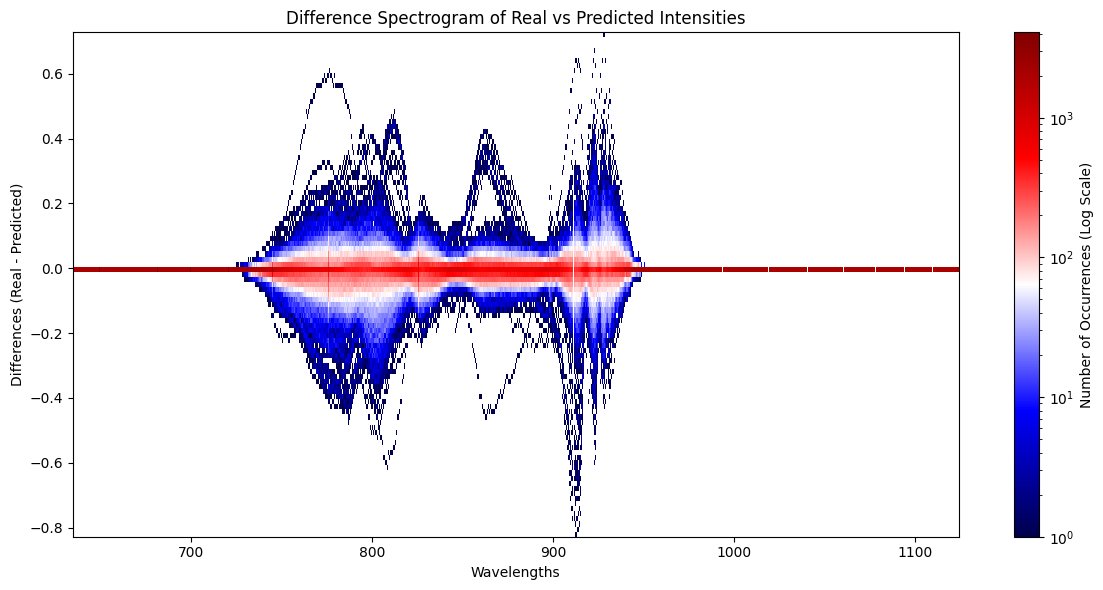

In [16]:
create_difference_spectrogram(wavelengths, 
                              x_real, 
                              predictions, 
                              label="Difference Spectrogram of Real vs Predicted Intensities")

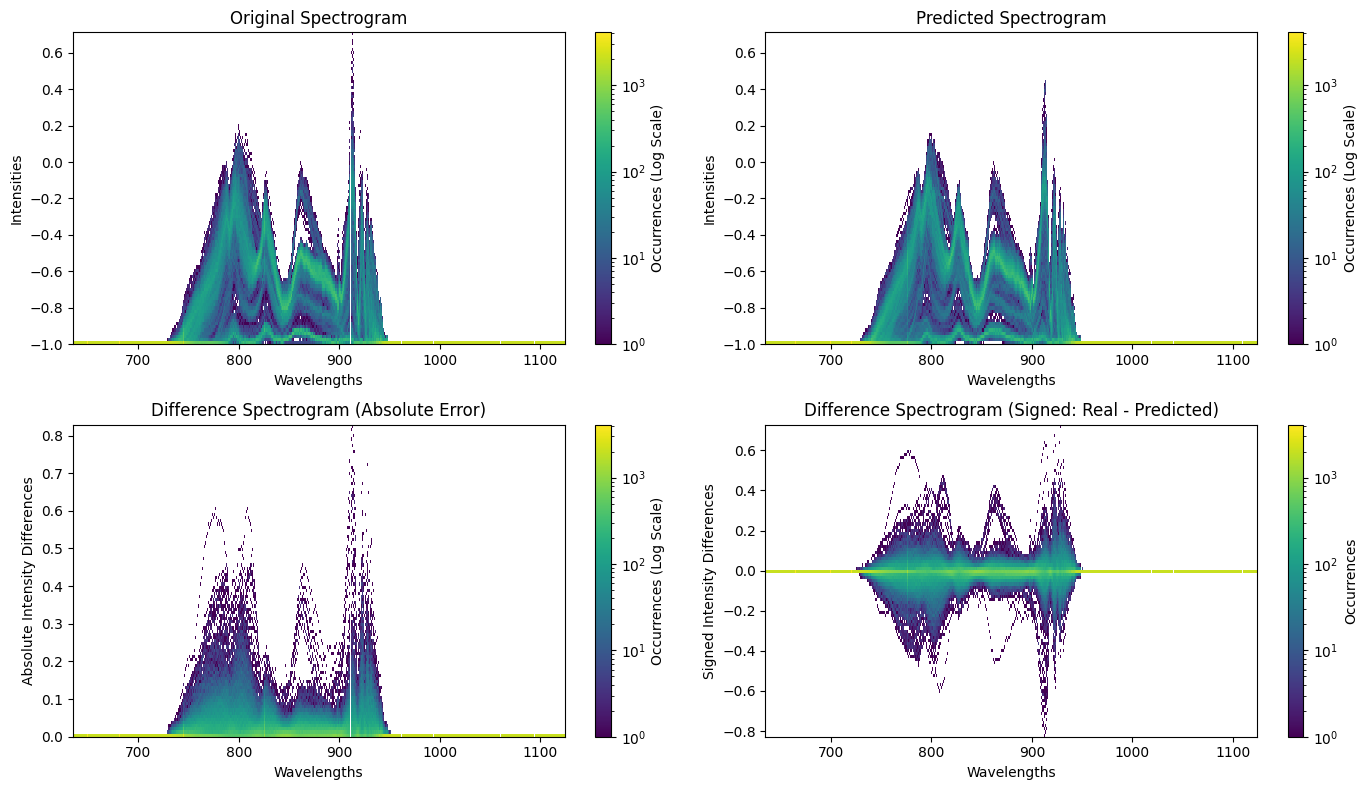

In [17]:
create_combined_spectrogram(wavelengths, 
                            x_real, 
                            predictions)

## Influence of parameters to predictions

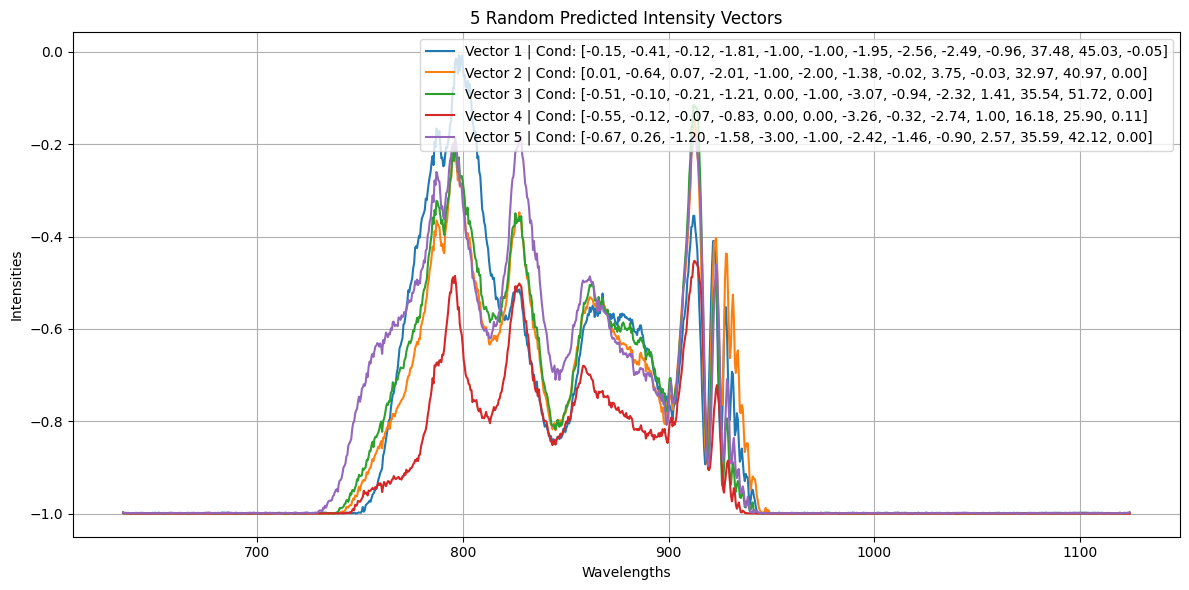

In [18]:
plot_random_intensity_vectors(wavelengths, predictions, cond_vectors)

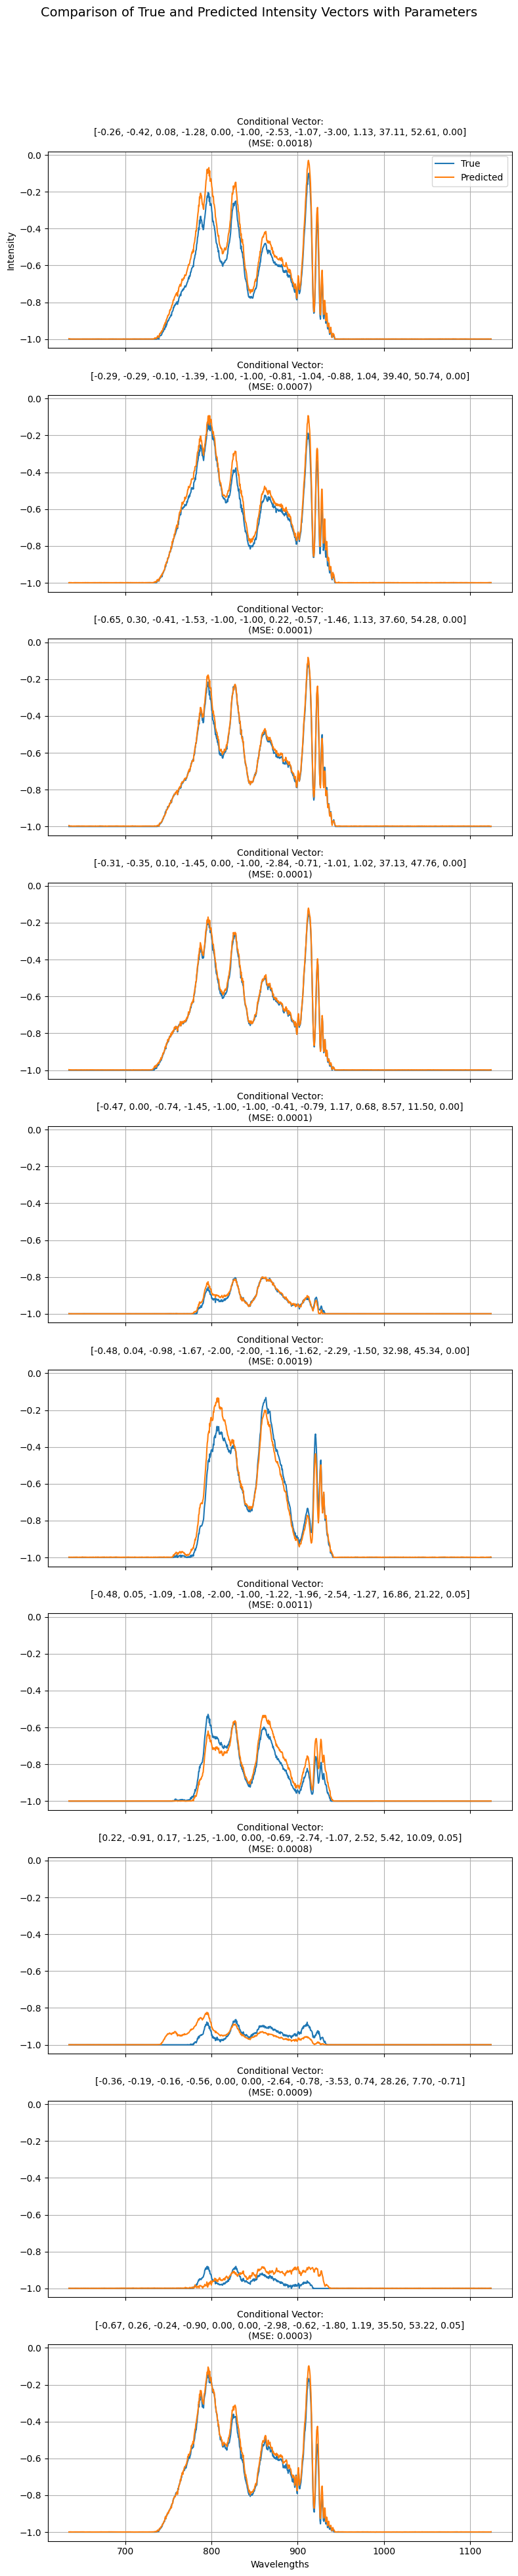

In [19]:
indices = np.random.choice(len(x_real), size=10, replace=False)

selected_real, selected_predicted, selected_conditions = plot_combined_intensity_vectors_with_parameters(
    wavelengths, x_real, predictions, cond_vectors, indices, num_vectors=10
)

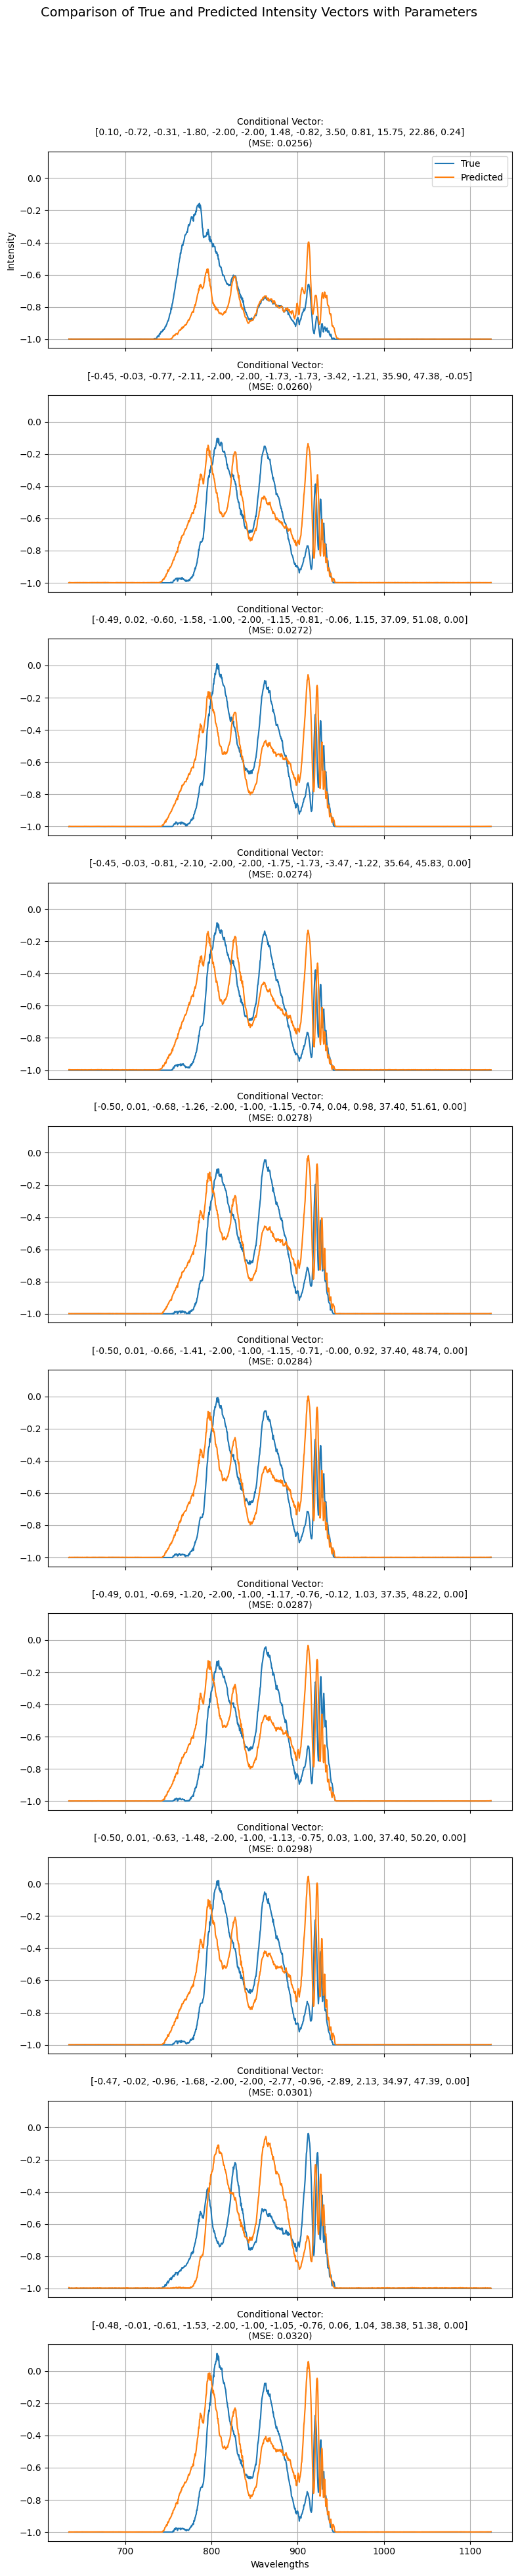

In [20]:
worst_indices = get_worst_mse_indices(x_real, predictions, n=10)
selected_real, selected_predicted, selected_conditions = plot_combined_intensity_vectors_with_parameters(
    wavelengths, x_real, predictions, cond_vectors, worst_indices, num_vectors=10
)

MSE Statistics:
Mean: 0.0011
Median: 0.0005
Standard Deviation: 0.0025
Min: 0.0000
Max: 0.0320
Range: 0.0320
Median (Q2): 0.0005
First Quartile (Q1): 0.0001
Third Quartile (Q3): 0.0011
Interquartile Range (IQR): 0.0009
Upper Whisker: 0.0025
Number of Outliers: 188.0000
Outliers: [0.0034510107873952254, 0.004537106524498641, 0.004396302795499426, 0.0050192605602504955, 0.003967379858689432, 0.0042105985504410845, 0.00276176646050546, 0.0034425630442867887, 0.026045718524263732, 0.02737782557657419]...


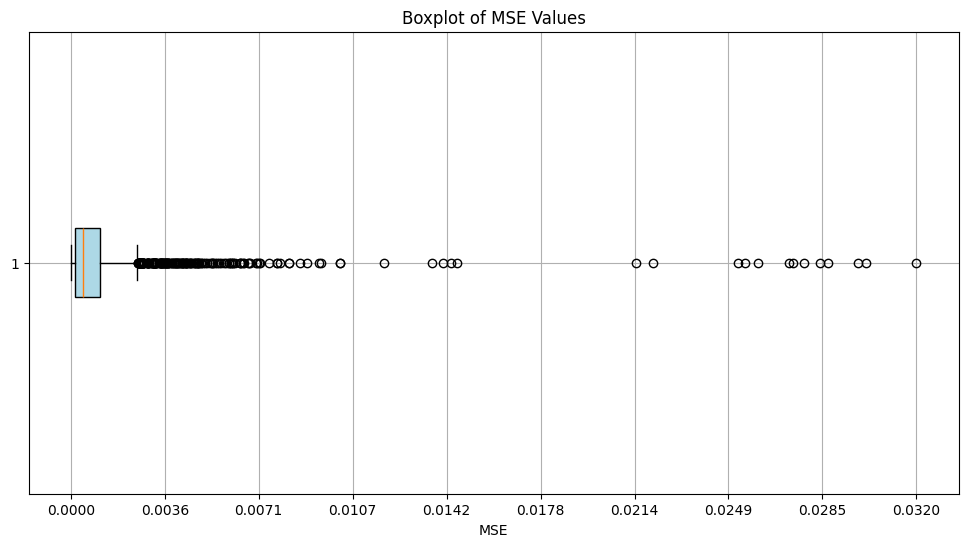

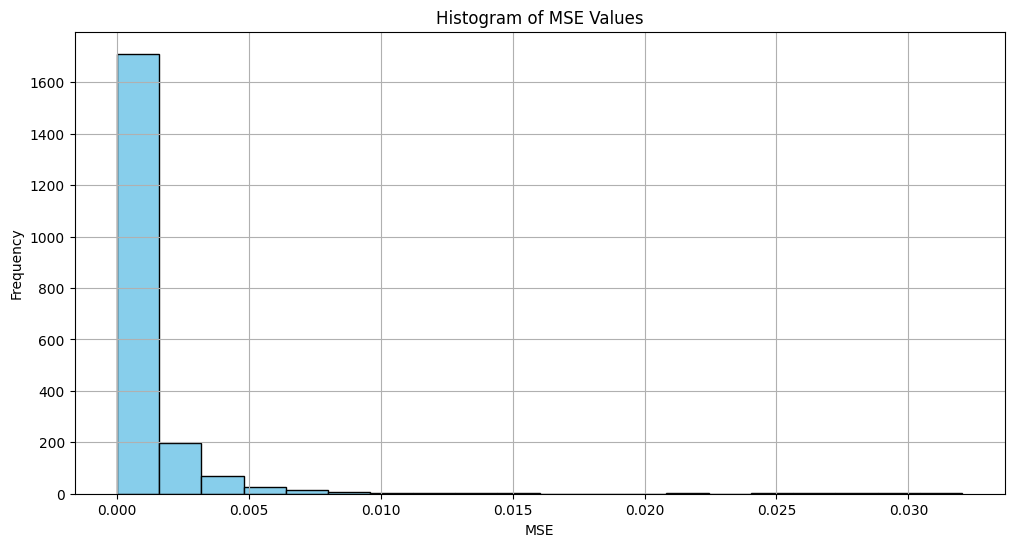

In [21]:
mse_stats = mse_statistics(x_real, predictions)

## Try Random conditional vectors

In [22]:
x_real_nonsense, cond_vectors_nonsense, predictions_nonsense = evaluate(model,
                                                                        scale_predictor,
                      sampler,
                      device,
                     "../data/data_nonsense.csv",
                                            s_type='edm')
x_real_nonsense = np.array(x_real_nonsense)
cond_vectors_nonsense = np.array(cond_vectors_nonsense)
predictions_nonsense = np.array(predictions_nonsense)[:,0,0,:]

NameError: name 'model' is not defined

In [ ]:
predictions_nonsense

In [ ]:
x_real_nonsense

In [ ]:
plot_predictions_with_cond_vectors(predictions_nonsense, cond_vectors_nonsense, num_rows=17)

## Compare distributions

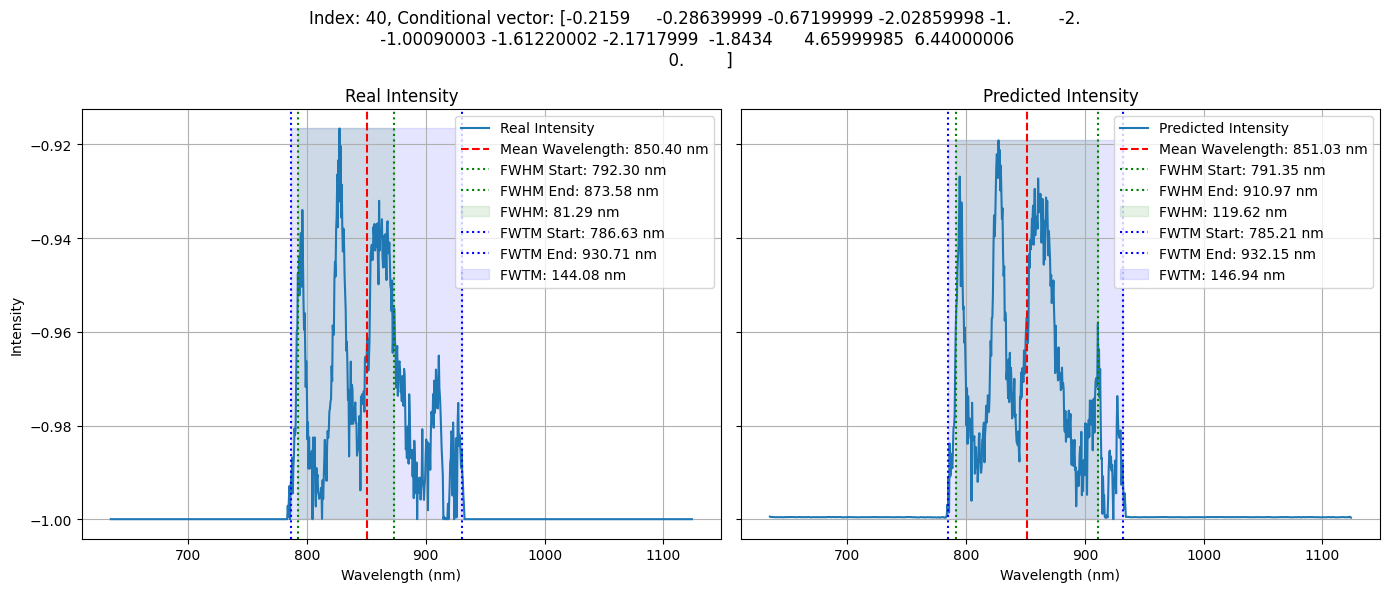

In [23]:
plot_comparison(index=40, wavelengths=wavelengths, x_real=x_real, predictions=predictions, cond_vectors=cond_vectors)

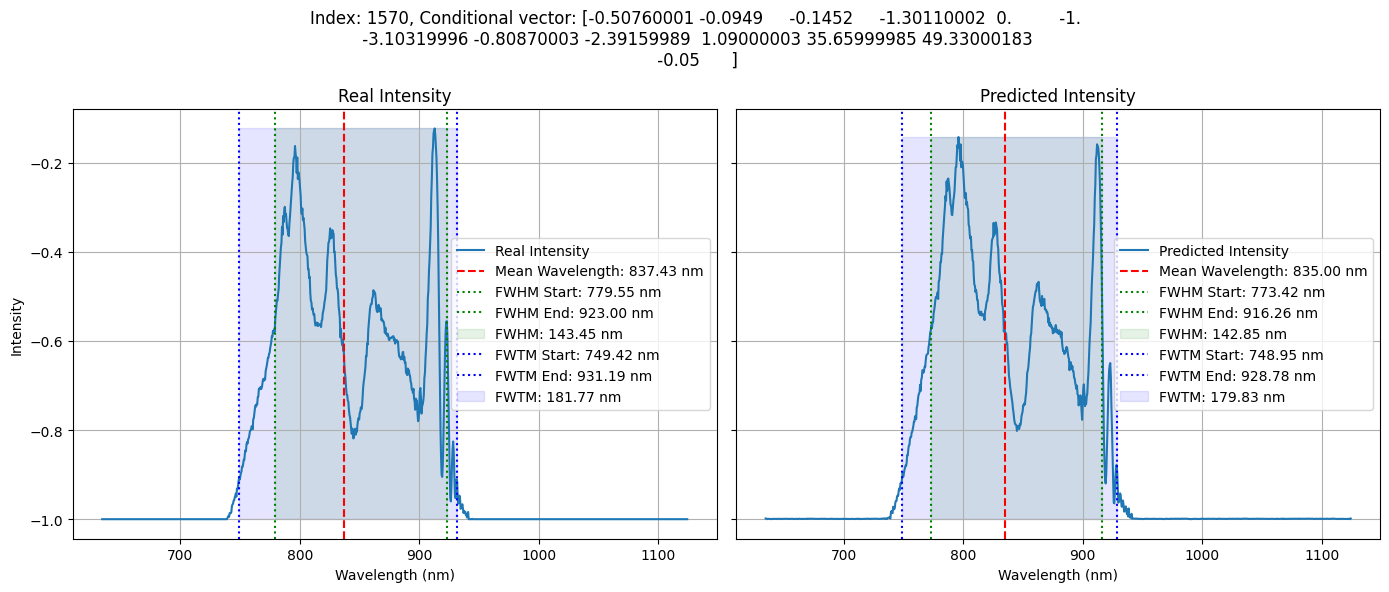

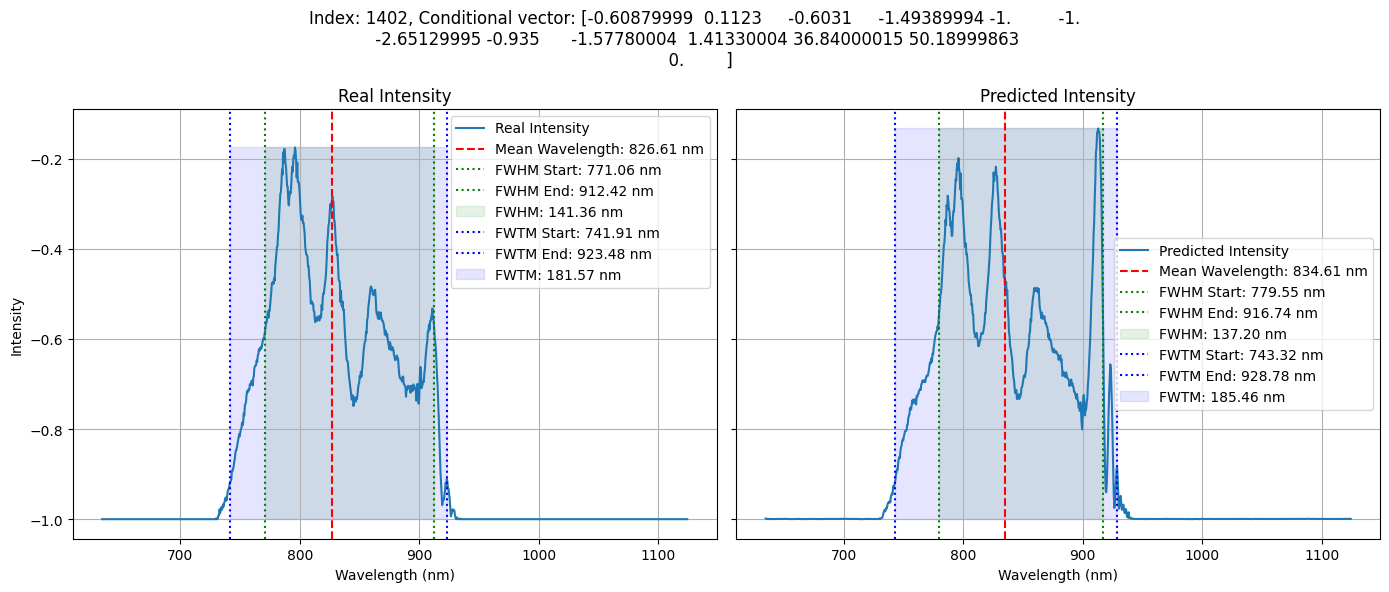

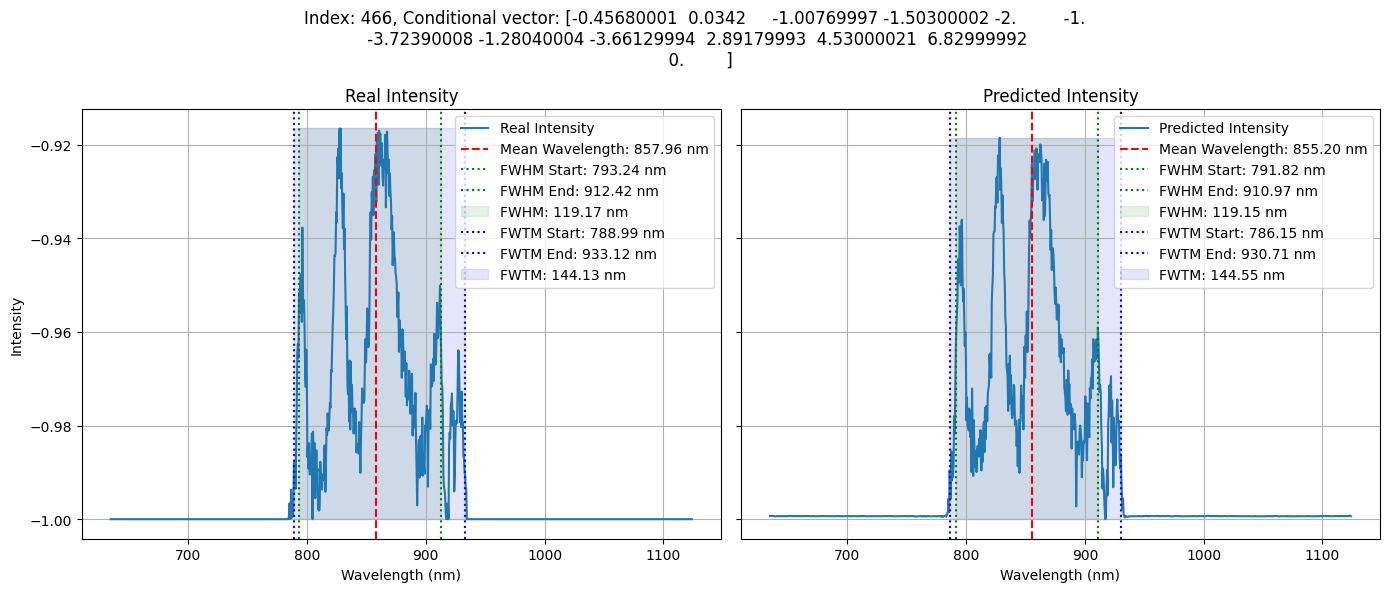

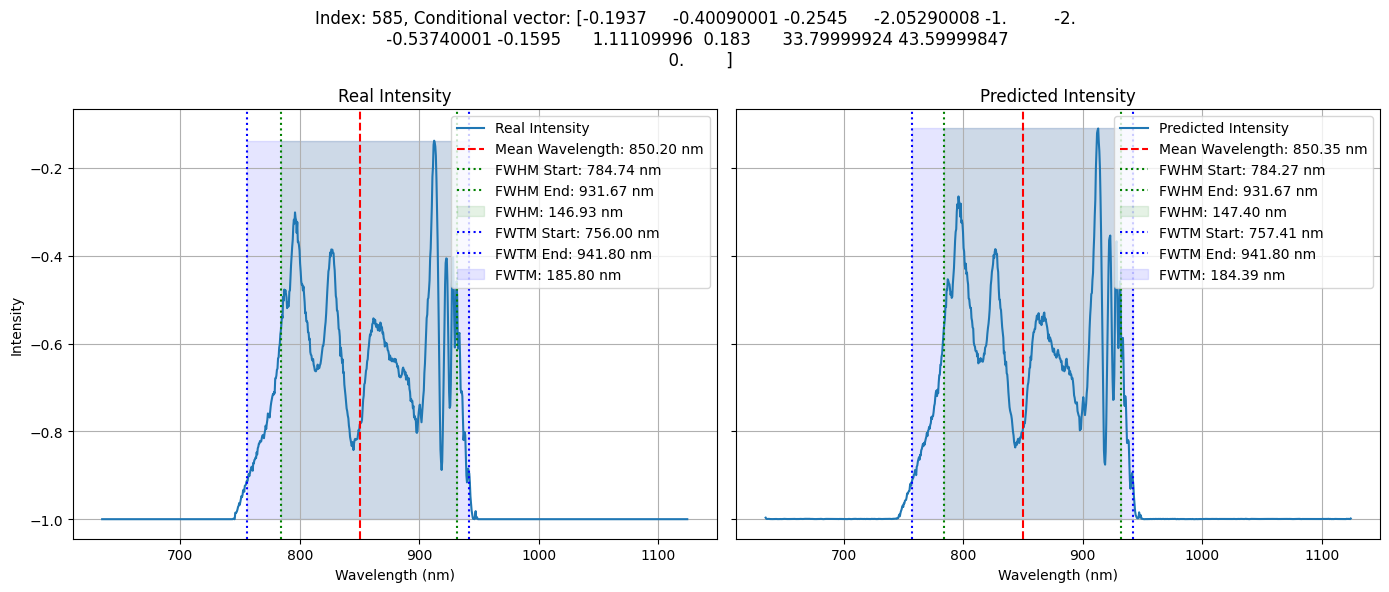

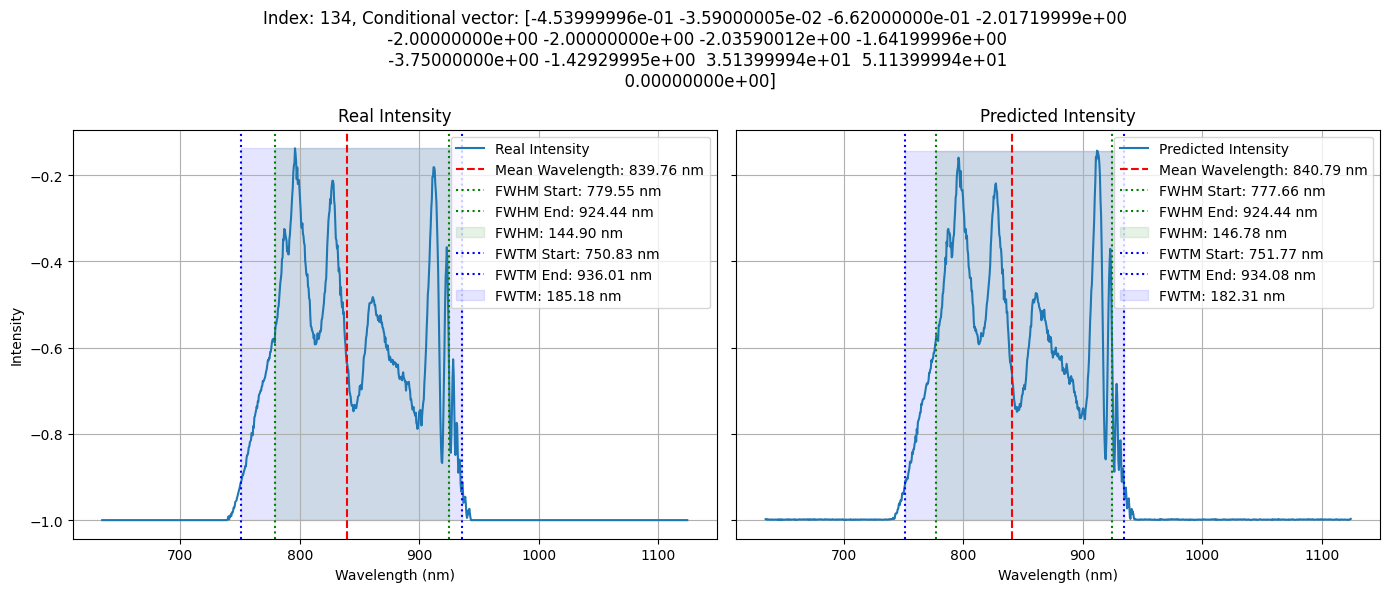

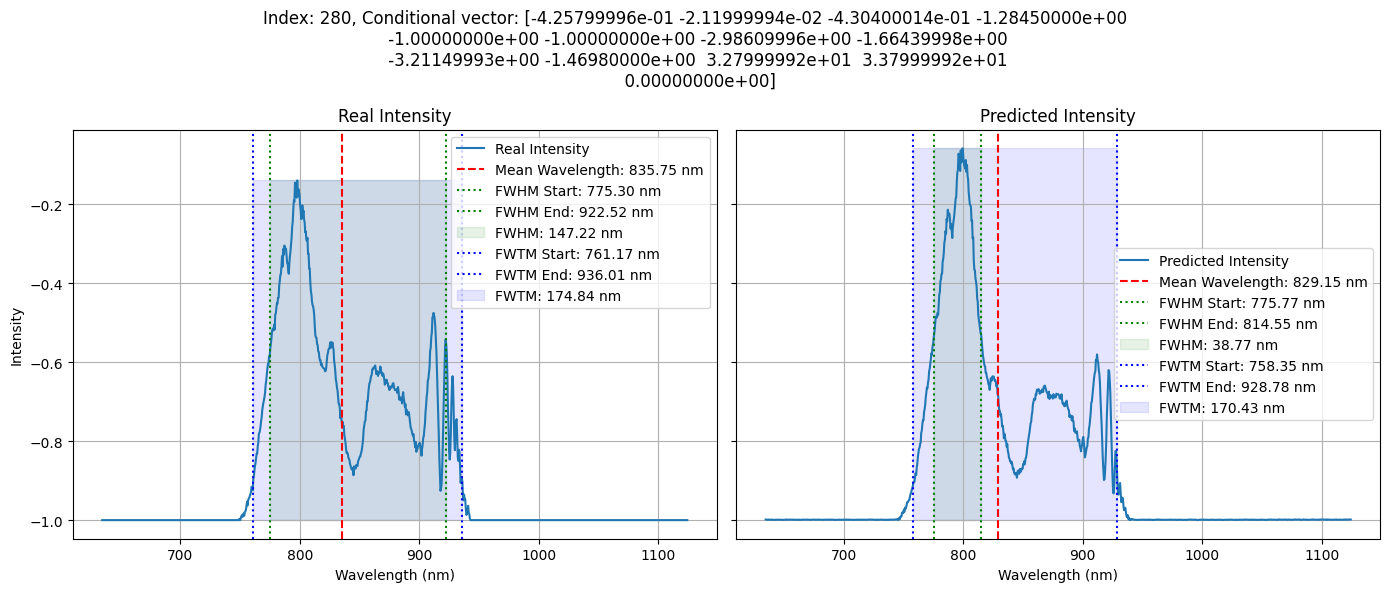

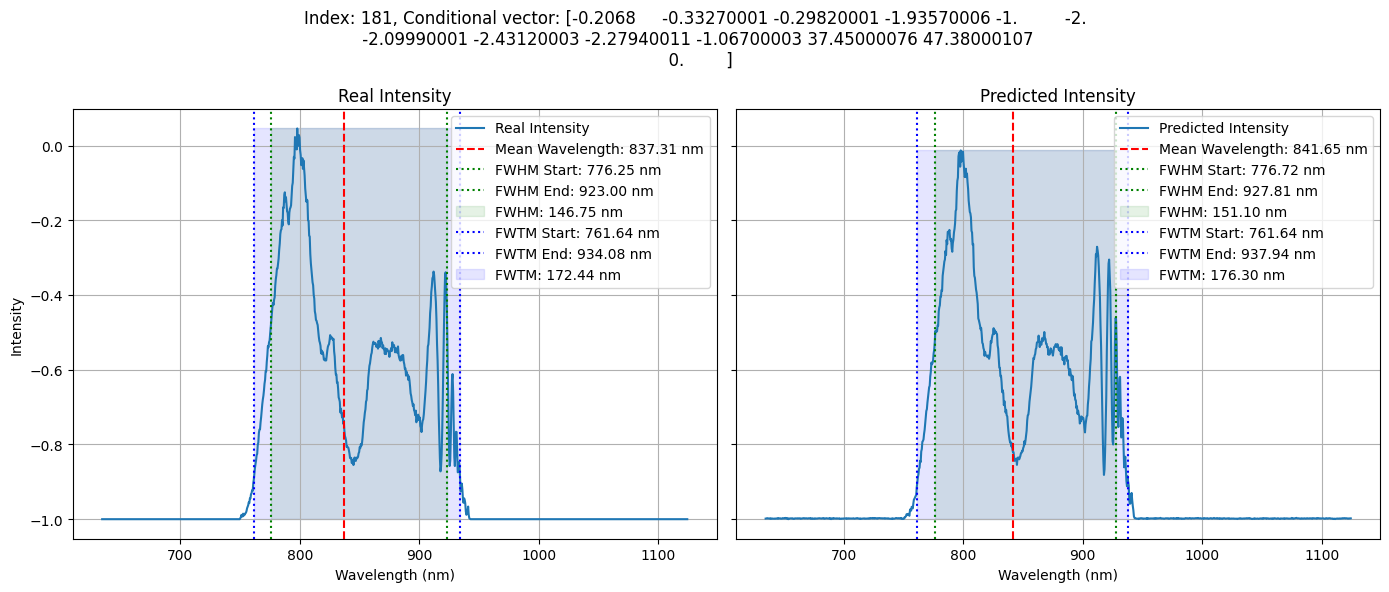

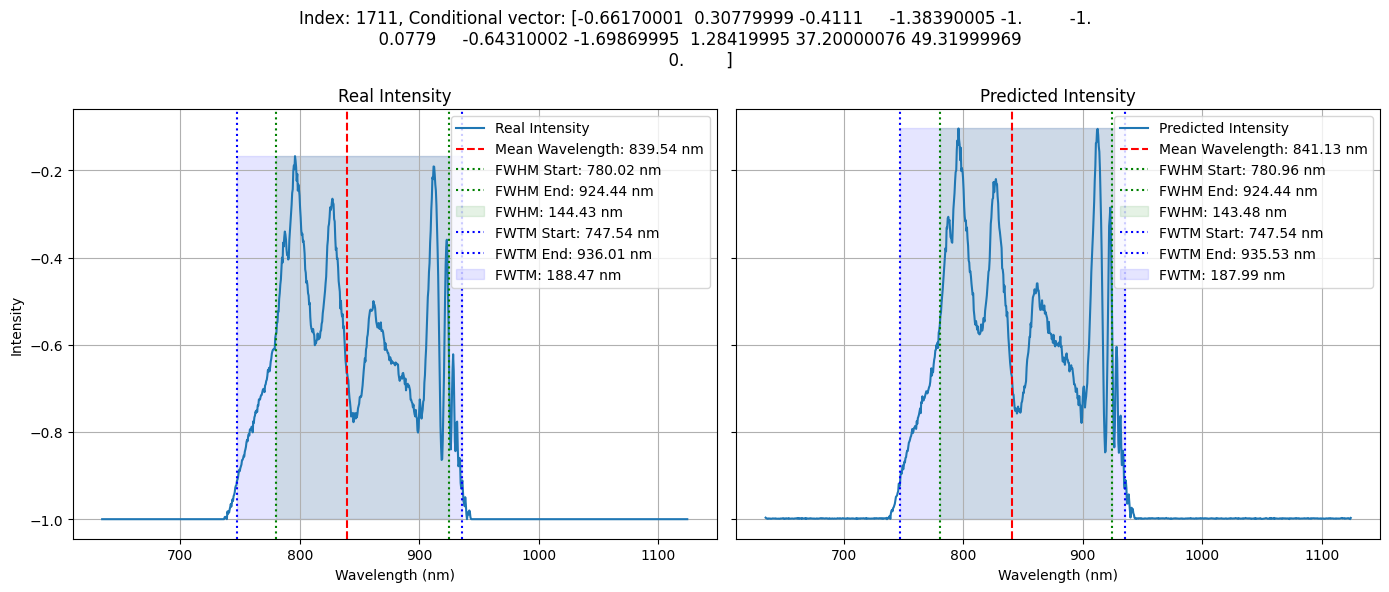

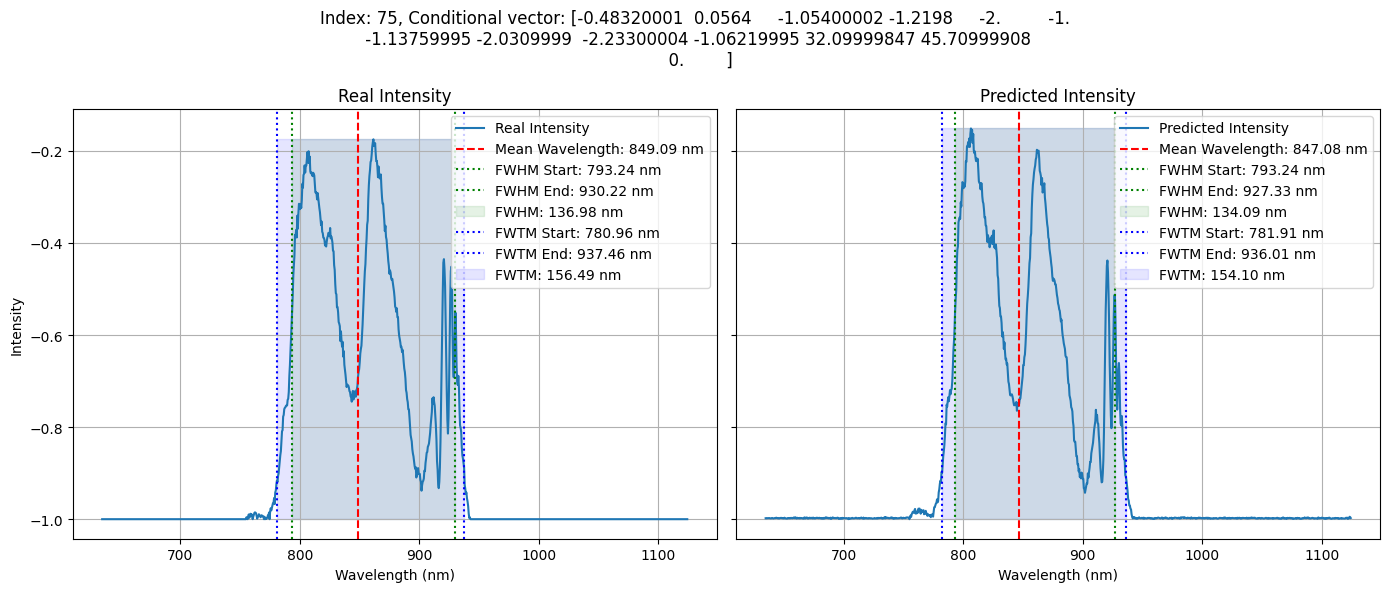

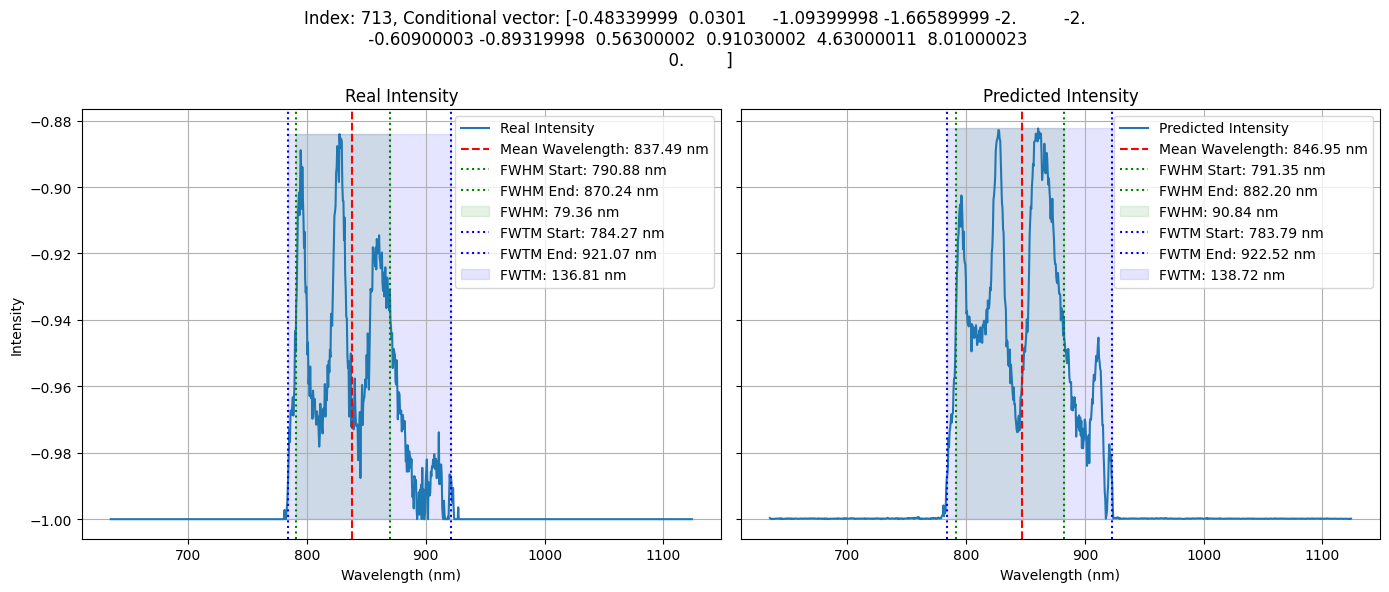

In [24]:
rand_ind = random.randint(len(x_real), size=(10))
for i in rand_ind:
    plot_comparison(index=i, wavelengths=wavelengths, x_real=x_real, predictions=predictions, cond_vectors=cond_vectors)

In [25]:
# Calculate MSE and MAE for the metrics
mse_results, mae_results = calculate_metrics_errors(wavelengths, x_real, predictions)

+-----------------+----------+----------+
| Metric          |      MSE |      MAE |
+=================+==========+==========+
| mean_wavelength |  44.8376 |  4.35131 |
+-----------------+----------+----------+
| std_deviation   |  32.6138 |  3.60377 |
+-----------------+----------+----------+
| fwhm            | 508.821  | 10.5991  |
+-----------------+----------+----------+
| fwhm_start      | 130.231  |  4.37982 |
+-----------------+----------+----------+
| fwhm_end        | 453.863  |  9.22659 |
+-----------------+----------+----------+
| fwtm            |  67.7924 |  4.53517 |
+-----------------+----------+----------+
| fwtm_start      |  35.9395 |  2.85228 |
+-----------------+----------+----------+
| fwtm_end        |  31.1295 |  3.00038 |
+-----------------+----------+----------+


### DTW

In [26]:
dtw_distances = calculate_dtw_distances(x_real, predictions)
mean_dtw = np.mean(dtw_distances)
print(f"Mean DTW Distance: {mean_dtw:.6f}")

Mean DTW Distance: 6.830505


[np.float64(2.2686097025871277),
 np.float64(1.8006770610809326),
 np.float64(1.5248333811759949),
 np.float64(2.041768193244934),
 np.float64(1.7218977808952332),
 np.float64(1.8299562335014343),
 np.float64(2.455381393432617),
 np.float64(2.1211905479431152),
 np.float64(1.9254955053329468),
 np.float64(2.171651780605316),
 np.float64(1.5389555096626282),
 np.float64(1.9596531987190247),
 np.float64(1.4858989715576172),
 np.float64(1.8936278820037842),
 np.float64(2.3765462040901184),
 np.float64(1.4660923480987549),
 np.float64(1.5264416337013245),
 np.float64(2.091158390045166),
 np.float64(3.0058836936950684),
 np.float64(1.5232601761817932),
 np.float64(2.186472713947296),
 np.float64(1.8828266263008118),
 np.float64(2.2966928482055664),
 np.float64(1.6281431317329407),
 np.float64(1.7009283304214478),
 np.float64(1.9670298099517822),
 np.float64(1.5705631971359253),
 np.float64(1.7682292461395264),
 np.float64(1.500516653060913),
 np.float64(1.4500688910484314),
 np.float64(1.69

DTW Distance for index 721: 2.128770


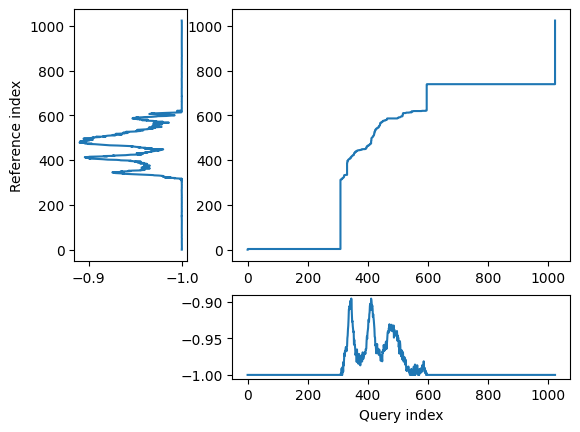

In [27]:
plot_dtw_alignment_for_index(x_real, predictions, 721)

DTW Distance for index 721: 2.128770


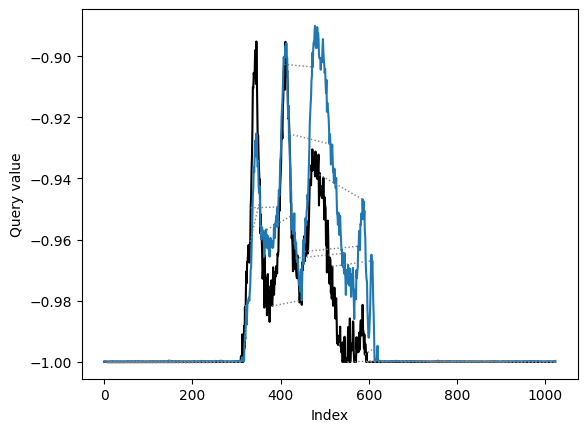

In [28]:
plot_dtw_alignment_for_index(x_real, predictions, 721, plot_type="twoway")

DTW Distance for index 1251: 24.332844


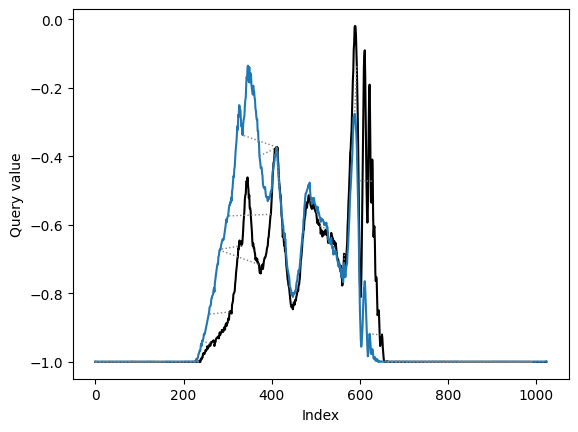

In [29]:
plot_dtw_alignment_for_index(x_real, predictions, 1251, plot_type="twoway")

### Wasserstein

In [30]:
wasserstein_distances, avg_distance = calculate_wasserstein_distance(x_real, predictions)
print(f"Average Wasserstein Distance: {avg_distance}")

Average Wasserstein Distance: 0.005597273095455194


In [33]:
min_values = np.min(wasserstein_distances, axis=0)  
max_values = np.max(wasserstein_distances, axis=0)  
mean_values = np.mean(wasserstein_distances, axis=0)  
median_values = np.median(wasserstein_distances, axis=0)  

print("Min:", min_values)
print("Max:", max_values)
print("Mean:", mean_values)
print("Median:", median_values)

Min: 0.0007592039178228029
Max: 0.02950382311573687
Mean: 0.005597273095455194
Median: 0.0010085414120503918
